Looking at Amazon's robots.txt file (or Twitter's, or Facebook's), you may be surprised to see them prohibit or severely restrict scraping.  Aren't there a lot of projects online using Twitter data?  And how dare they keep all that delicious, delicious information to themselves?  But before you start setting `'ROBOTSTXT_OBEY' = False`, read on!

Most of The Big Websites (Google, Facebook, Twitter, etc) have APIs that allow you to access their information programmatically without using webpages.  This is good for both you and the website.  With an API, you can ask the server to send you only the specific information you want, without having to retrieve, filter out, and discard the CSS, HTML, PHP, and other code from the website.  This minimizes demand on the server and speeds up your task.  

APIs typically include their own throttling to keep you from overloading the server, usually done by limiting the number of server requests per hour to a certain number.  

To access an API, you will usually need an API key or token that uniquely identifies you.  This lets the company or service providing the API keep an eye on your usage and track what you are doing.  Different API keys can also be associated with different levels of authorization and access, so they work as a data security measure.  Keys or tokens may also be set to expire after a certain amount of time or number of uses.

## Anatomy of an API

*Access*- You request a key.  Your program provides the key with each API call, and it determines what your program can do in the API.  
*Requests*- Your program requests the data you want with a call to the API.  The request will be made up of a method (type of query, using language defined by the API) and parameters (refine the query).  
*Response*- The data returned by the API, usually in a common format such as JSON that your program can parse.  

The specific syntax for each of these elements, and the format of the response, will vary from API to API.  In addition, APIs vary widely in their level of documentation and ease of use.  Before diving too deeply into an API-scraping project, do some judicious googling and if you see a lot of posts [like this one](https://mollyrocket.com/casey/stream_0029.html) consider going elsewhere.  Not all websites put their APIs front-and-center (did you know there are APIs for [NASA](https://api.nasa.gov/), [Marvel Comics](http://developer.marvel.com/), and [Star Wars](https://swapi.co/)?) so google will be your friend there as well.

## Basics of API Queries: Wikipedia's API

The process of using an API sounds a lot like scraping (make request, get response), but with an occasional added authorization layer.  Scrapy can handle authorization, so we can use it to access APIs too.

That said, the first API we'll pull from is [Wikipedia's](https://www.mediawiki.org/wiki/API:Main_page), which doesn't require an authorization key.  Aside from needing to master the API's language, you'll find that using scrapy with an API is very similar to using scrapy on a website.

We want to know what other entries on Wikipedia link to the [Monty Python](https://en.wikipedia.org/wiki/Monty_Python) page.  To do this, we can build a query using the [Wikipedia API Sandbox](https://en.wikipedia.org/wiki/Special:ApiSandbox).  Someone who is comfortable with the MediaWiki API syntax wouldn't need to use the sandbox, but for beginners it is very handy.  Note that API queries are nothing like SQL queries in syntax, despite their shared name.

The query we will use looks like this:
`https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect`

Let's break that down into it's components:

* `w/api.php`
    * Tells the server that we are using the API to pull info, rather than scraping the raw pages.  
    
* `action=query`   
    * We want information from the API (as opposed to changing information in the API)  
    
* `format=xml`  
    * Format the return in xml- then we will parse it with xpath  
    
* `prop=linkshere`  
    * We are interested in which pages link to our target page 
    
* `titles=Monty_Python`  
    * The target page is the Monty Python page.  Note that we used the exact name of the wikipedia page (Monty_Python).  
    
* `lhprop=title`  
    * From those links, we want the title of each page  
    
* `redirect`  
    * We also want to know if that link is a redirect  
    

The syntax of the MediaWiki API is based on php, thus the inclusion of `?` and `&` in the query.

For most of the query elements, we could have passed multiple arguments.  For example, we could request the URL as well as the title of the linking pages, or asked for all the pages that link to Monty_Python and to Monty_Python's_Flying_Circus.  

A query like this highlights why APIs are so handy.  Without an API, to find out the name of every page on Wikipedia that links to the Monty Python page we would have to scrape every single one of the 5,000,000+ articles in the English-language Wikipedia.  

If you haven't done so already, click on the query link above and see what it returns.



## Why use Scrapy for API calls

For some API calls, scrapy would be overkill.  If you know that your query can be answered in one response, then you don't need scrapy- you can use the `requests` library to make your API call and a library like `lxml` to parse the return.

The Wikipedia API, however, will only return ten items at a time in response to a query.  This sort of limitation is common to APIs to avoid overwhelming the server.  We can use scrapy to iterate over query results the same way that we iterated over the pages of the EverydaySexism website. 

Let's see the Wikipedia API and scrapy in action:



In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class WikiSpider(scrapy.Spider):
    name = "WS"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//lh'):
            # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
            # Other codes indicate links from 'Talk' pages, etc.  Since we are only interested in entries, we filter:
            if item.xpath('@ns').extract_first() == '0':
                yield {
                    'title': item.xpath('@title').extract_first() 
                    }
        # Getting the information needed to continue to the next ten entries.
        next_page = response.xpath('continue/@lhcontinue').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'PythonLinks.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 10
})
                                         

# Starting the crawler with our spider.
process.crawl(WikiSpider)
process.start()
print('First 100 links extracted!')

First 100 links extracted!


In [2]:
import pandas as pd

# Checking whether we got data 

Monty=pd.read_json('PythonLinks.json', orient='records')
print(Monty.shape)
print(Monty.tail())

(92, 1)
                        title
87               Hans Moleman
88              Ripping Yarns
89  List of British comedians
90         Wensleydale cheese
91              Art Garfunkel


## Wrap up

Our API call was successful.  While we examined 100 links, we only saved 92 (the others weren't links from entry pages).  

We've barely scraped (pun intended) the surface of what scrapy and APIs can do.  Scrapy has changed a lot in the years since its debut, so when googling make sure the answers you see are from 2015 at the latest-- otherwise you'll likely not be able to use the code.  

Back to the issue of authorization keys- often the key is simply included in the query string as an additional arguments.  In other cases, if you need your scraper to be able to enter a key or login information into a form, scrapy [has you covered](http://stackoverflow.com/questions/30102199/form-authentication-login-a-site-using-scrapy).  

There's a lot of fun to be had in scraping and APIs-- it's a way to feel like you're getting a lot of information with very little effort!  Beware, however.  You're not getting information at all.  Scraping gives you *data*, an undifferentiated mess of bytes with no compelling meaning on its own.  Think of that list of Wiki entries that link to Monty Python.  It's cool that we could get it, but what does it mean?  Your job as a data scientist is to convert *data* to *information*-- something people can use to make decisions or understand the world.  Modeling data to get information is hard but worthwhile work, and its those kinds of projects that will really build your portfolio as you go on the market.  

That said, scraping up some original data can provide the *foundation* for an interesting and original final project.

## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

In [ ]:
#Let's retrieve some information from Yelp (API is no longer open to public)

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class YelpSpider(scrapy.Spider):
    name = "YS"
    
    #scrapy might have it's own init method, but we don't want to interfere with that
    ####EXAMPLE
    #def func(a,b,*args,**kwargs):
    #print(a)
    #print(b)
    #print(args)
    #print(kwargs)
    
    #func(2,3,4,5,c=6)

    # *args will capture any non-specified arguments that don't fit function parameters
    # **kwargs will capture the same, but these are named inputs to the function that arent part of the regular parameters
    
    #Keep track of how many pages we have visited using 'i'
    
    def __init__(self, *args, **kwargs):
        self.i = 0
        #since we intercepted the init function here, let's call the original init method for scrapy.Spider and 
        #plug in (unpack) the *args and **kwargs, if any
        super().__init__(*args, **kwargs)
        
    
    # Here is where we insert our API call. Begin at breakfast & brunch search page for NYC
    start_urls = [
        'https://www.yelp.com/search?find_desc=breakfast+%26+brunch&find_loc=New+York,+NY&start=0'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
    
        
        #//li is the identifier used for each listing (per inspect-->elements )
        for listing in response.xpath('//li[@class="regular-search-result"]'):
 
    #Tips: https://www.w3schools.com/xml/xpath_syntax.asp
    #// :  Selects nodes in the document from the current node that match the selection no matter where they are
    #. : Selects the current node

                yield {
                    'name' : listing.xpath(".//span[@class='indexed-biz-name']/a/span/text()").extract_first(),
                    'rating' : listing.xpath(".//div[@class='biz-rating biz-rating-large clearfix']//@title").extract_first(),
                    'price' : listing.xpath(".//span[@class='business-attribute price-range']/text()").extract_first(),
                    'reviews' : listing.xpath(".//span[@class='review-count rating-qualifier']/text()").extract_first(),
                    #extract instead of extract_first because we want all elements in category list
                    'categories' : listing.xpath(".//span[@class='category-str-list']//a/text()").extract(),
                    }
        
        #Increment i (page count) and multiply by 10 (10 entries per page)
        self.i += 1
        
        # Getting the information needed to continue to the next ten entries.
        if self.i <= 99:
            next_page = 'https://www.yelp.com/search?find_desc=breakfast+%26+brunch&find_loc=New+York,+NY&start={}'.format(self.i*10)
        else:
            next_page = None
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
        #    next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    #URI requires 'file:///' at beginning on Windows systems
    'FEED_URI': r'file:///C:/Users/ryan/Desktop/Thinkful DS Sample Data - Main Course/Unit 5/yelptest21.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 1000 entries (100 pages).    
    'CLOSESPIDER_PAGECOUNT' : 100
})
                                         

# Starting the crawler with our spider.
process.crawl(YelpSpider)
process.start()
print('First 1000 links extracted!')

First 1000 links extracted!


In [2]:
import pandas as pd
yelpdf=pd.read_json('C:/Users/ryan/Desktop/Thinkful DS Sample Data - Main Course/Unit 5/yelptest21.json', orient='records')
yelpdf.head()

,categories,name,price,rating,reviews
0,"[Breakfast & Brunch, Cocktail Bars, Juice Bars...",Hole in the Wall,$$,4.5 star rating,\n 135 reviews\n
1,[Breakfast & Brunch],Lella Alimentari,$,5.0 star rating,\n 85 reviews\n
2,"[Breakfast & Brunch, American (New), Southern]",Sweet Chick,$$,4.0 star rating,\n 85 reviews\n
3,"[Sandwiches, Mediterranean, Breakfast & Brunch]",Rustic Table,$$,4.5 star rating,\n 362 reviews\n
4,"[American (New), Cocktail Bars, Breakfast & Br...",The Wild Son,$$,4.5 star rating,\n 192 reviews\n


In [29]:
#Create a unique set of categories using the set.update fcn
cat_set = set()
yelpdf['categories'].apply(cat_set.update)

In [31]:
cat_set

{'American (New)',
 'American (Traditional)',
 'Asian Fusion',
 'Australian',
 'Austrian',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Basque',
 'Beer Bar',
 'Beer, Wine & Spirits',
 'Belgian',
 'Beverage Store',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'British',
 'Buffets',
 'Burgers',
 'Butcher',
 'Cafes',
 'Cafeteria',
 'Cajun/Creole',
 'Cantonese',
 'Caribbean',
 'Caterers',
 'Cheese Shops',
 'Chinese',
 'Chocolatiers & Shops',
 'Cocktail Bars',
 'Coffee & Tea',
 'Coffee Roasteries',
 'Colombian',
 'Comedy Clubs',
 'Comfort Food',
 'Convenience Stores',
 'Creperies',
 'Cuban',
 'Custom Cakes',
 'Delis',
 'Desserts',
 'Diners',
 'Dinner Theater',
 'Dominican',
 'Donuts',
 'Falafel',
 'Farmers Market',
 'Fast Food',
 'Filipino',
 'Fish & Chips',
 'Food Court',
 'Food Stands',
 'Food Trucks',
 'French',
 'Gastropubs',
 'German',
 'Gluten-Free',
 'Greek',
 'Halal',
 'Health Markets',
 'Himalayan/Nepalese',
 'Hot Dogs',
 'Ice Cream & Frozen Yogurt',
 'Internet Cafes',
 

In [16]:
#For each category we defined, test whether that category is in the list of categories for each restaurant
for cat in cat_set:
    yelpdf[cat] = yelpdf['categories'].apply(lambda x: cat in x)

In [17]:
yelpdf.head()

,categories,name,price,rating,reviews,Singaporean,Breakfast & Brunch,Dominican,Soul Food,Filipino,...,Middle Eastern,Venezuelan,Sandwiches,Polish,Pop-Up Restaurants,Piadina,Lebanese,Music Venues,Thai,Whiskey Bars
0,"[Breakfast & Brunch, Cocktail Bars, Juice Bars...",Hole in the Wall,$$,4.5 star rating,\n 135 reviews\n,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,[Breakfast & Brunch],Lella Alimentari,$,5.0 star rating,\n 85 reviews\n,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"[Breakfast & Brunch, American (New), Southern]",Sweet Chick,$$,4.0 star rating,\n 85 reviews\n,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"[Sandwiches, Mediterranean, Breakfast & Brunch]",Rustic Table,$$,4.5 star rating,\n 362 reviews\n,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,"[American (New), Cocktail Bars, Breakfast & Br...",The Wild Son,$$,4.5 star rating,\n 192 reviews\n,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
# '\n' is considered whitespace, and can be removed by the strip fcn
#Combine strip, rstrip, and astype to get an int count of reviews for each restaurant
yelpdf['reviews'] = yelpdf['reviews'].str.strip().str.rstrip(' reviews').astype(int)

In [37]:
#Convert price to int ($$ to 2, for example)
yelpdf['price'] = yelpdf['price'].apply(lambda x: len(str(x)))

In [49]:
#Trim rating string and convert to decimal
yelpdf['rating'] = yelpdf['rating'].str.rstrip(' star rating').astype(float)

In [54]:
yelpdf.drop('categories', inplace = True, axis = 1)

In [55]:
yelpdf.head()

,name,price,rating,reviews,Singaporean,Breakfast & Brunch,Dominican,Soul Food,Filipino,German,...,Middle Eastern,Venezuelan,Sandwiches,Polish,Pop-Up Restaurants,Piadina,Lebanese,Music Venues,Thai,Whiskey Bars
0,Hole in the Wall,2,4.5,135,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Lella Alimentari,1,5.0,85,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Sweet Chick,2,4.0,85,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Rustic Table,2,4.5,362,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,The Wild Son,2,4.5,192,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Time for some summarizations!

In [69]:
import numpy as np
yelpdf.describe()

,price,rating,reviews
count,1000.000000,1000.000000,1000.000000
mean,1.846000,4.036000,297.767000
std,0.592144,0.390329,406.922632
min,1.000000,3.000000,1.000000
25%,1.750000,4.000000,69.000000
50%,2.000000,4.000000,166.500000
75%,2.000000,4.500000,355.750000
max,4.000000,5.000000,3772.000000


Clearly the reviews skew very positive for brunch spots in NYC, with the lowest rated spot receiving a 3 star rating and the average spot receivinga  4.036!

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

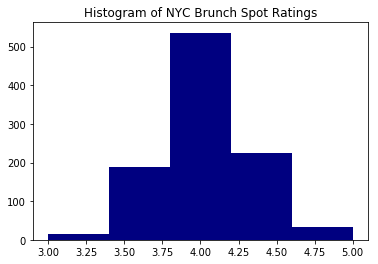

In [117]:
plt.hist(yelpdf['rating'], bins=5, color= 'navy')
plt.title('Histogram of NYC Brunch Spot Ratings')
plt.show()

In [123]:
yelpdf.head()

,name,price,rating,reviews,Singaporean,Breakfast & Brunch,Dominican,Soul Food,Filipino,German,...,Middle Eastern,Venezuelan,Sandwiches,Polish,Pop-Up Restaurants,Piadina,Lebanese,Music Venues,Thai,Whiskey Bars
0,Hole in the Wall,2,4.5,135,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Lella Alimentari,1,5.0,85,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Sweet Chick,2,4.0,85,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Rustic Table,2,4.5,362,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,The Wild Son,2,4.5,192,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


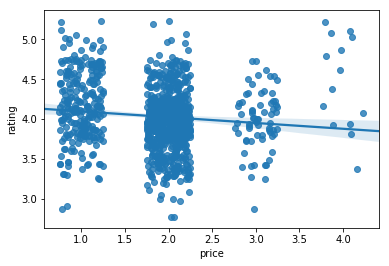

In [146]:
#Take a look at the relationship between price and rating
%matplotlib inline
sns.regplot(yelpdf['price'], yelpdf['rating'], x_jitter=0.25, y_jitter=0.25)

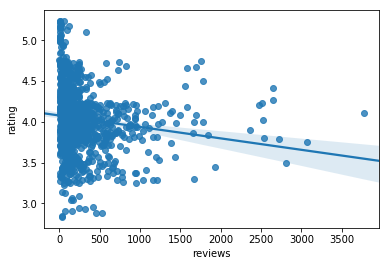

In [151]:
#Take a look at the relationship between reviews and rating
sns.regplot(yelpdf['reviews'], yelpdf['rating'], y_jitter=0.25)

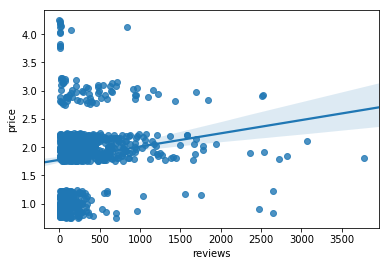

In [152]:
#Take a look at the relationship between reviews and price
sns.regplot(yelpdf['reviews'], yelpdf['price'], y_jitter=0.25)

In [113]:
#Show average review by category for restaurants with > 10 reviews & sort by average rating
avg_ratings = []
for cat in cat_set:
    avg_ratings.append(round(np.mean(yelpdf['rating'][(yelpdf['reviews'] > 10) & (yelpdf[cat] == True)]), 1))

In [115]:
cat_df = pd.DataFrame()
cat_df['Category'] = list(cat_set)
cat_df['Avg_Rating'] = avg_ratings

In [119]:
cat_df.sort_values(by = 'Avg_Rating', ascending=False)

,Category,Avg_Rating
103,Tiki Bars,5.0
118,Piadina,5.0
117,Pop-Up Restaurants,5.0
0,Singaporean,4.5
48,Hot Dogs,4.5
33,Basque,4.5
35,Moroccan,4.5
72,Malaysian,4.5
95,"Beer, Wine & Spirits",4.5
93,Street Vendors,4.5
